<a href="https://colab.research.google.com/github/sreshu/MovieAnalysis/blob/main/MovieLensAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing all the neccesary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the movie lens dataset directly to colab
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip


--2023-08-10 11:15:09--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  77.7MB/s    in 3.5s    

2023-08-10 11:15:13 (72.4 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [3]:
#unzipping the data to read the csv's
local_zip = './ml-25m.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [4]:
%%time

#consisit of 25M ratings
rating_df = pd.read_csv('/ml-25m/ratings.csv')

#consist of tags/comments from user
tags_df = pd.read_csv('/ml-25m/tags.csv')

#consist of movie titles
title_df = pd.read_csv('/ml-25m/movies.csv')

CPU times: user 9.73 s, sys: 1.5 s, total: 11.2 s
Wall time: 11.3 s


In [5]:
#looking for some initial statistics of data
print('No of Users who rated movies:', rating_df.userId.nunique())
print('No of Movies:', rating_df.movieId.nunique())
print('No of ratings:', rating_df.rating.count())
print('No of user comments:', tags_df.tag.nunique())
print('No of Movies commented by user:', tags_df.movieId.nunique())
print('Percentage of user commented:', (tags_df.tag.nunique()/rating_df.userId.nunique())*100, '%')
print('No of movies commented by user:', (tags_df.movieId.nunique()/rating_df.movieId.nunique())*100, '%')

No of Users who rated movies: 162541
No of Movies: 59047
No of ratings: 25000095
No of user comments: 73050
No of Movies commented by user: 45251
Percentage of user commented: 44.942506813665474 %
No of movies commented by user: 76.63556150185445 %


In [5]:


df1 = rating_df.copy()
df2 = tags_df.copy()
df3 = title_df.copy()

#deleted timestamps
del df1['timestamp']
del df2['timestamp']



In [6]:
# seperate year from title
#seperate genre in each colum

#add year from title feature
ss = df3['title'].str.findall('\((\d{4})\)').str.get(0)
df3['Year'] = ss

#seperate genre for each movie and count genres
sss = df3['genres'].str.split(pat='|', expand=True).fillna(0)
sss.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
cols = sss.columns
sss[cols] = sss[cols].astype('category')
ss1 = sss.copy()
cat_columns = ss1.select_dtypes(['category']).columns

#count genres (non zeros)
ss1[cat_columns] = ss1[cat_columns].apply(lambda x: x.cat.codes)
ss1['genre_count'] = ss1[cols].gt(0).sum(axis=1) #count greater than 0 values for less than: df[cols].lt(0).sum(axis=1), for equal==0: df[cols].eq(0).sum(axis=1)

#assigning everything to same dataframe
df3['genre_count'] = ss1['genre_count']
df3[cols] = sss[cols]

df3.head()

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,1,Comedy,0,0,0,0,0,0,0,0,0


In [7]:
#avg movie ratings by movied id and count
#avg movie ratings by user id and count
rating_avg = df1.groupby('movieId')['rating'].mean().reset_index()
rating_avg = pd.DataFrame(rating_avg)

rating_count = df1.groupby('movieId')['rating'].count().reset_index()
rating_count = pd.DataFrame(rating_count)
rating_count.rename({'rating': 'rating_count'}, axis=1, inplace=True)

user_rating = df1.groupby('userId')['rating'].mean().reset_index()
user_rating = pd.DataFrame(user_rating)

user_count = df1.groupby('userId')['rating'].count().reset_index()
user_count = pd.DataFrame(user_count)
user_count.rename({'rating': 'rating_count'}, axis=1, inplace=True)

df_movie = rating_avg.merge(rating_count, on = 'movieId', how='inner')

df_user = user_rating.merge(user_count, on = 'userId', how='inner')


In [8]:
df_user.head() #avg rating given by a user and its count


,userId,rating,rating_count
0,1,3.814286,70
1,2,3.630435,184
2,3,3.697409,656
3,4,3.378099,242
4,5,3.752475,101


In [9]:
df_movie.head() #avg rating on a movie and count

,movieId,rating,rating_count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


In [10]:
#add genre to tags_df --> for word cloud
cols = ['movieId','genre1']
dfk = df3[cols]
df2 = df2.merge(dfk, on = 'movieId', how='inner')
df2.head(3)


,userId,movieId,tag,genre1
0,3,260,classic,Action
1,3,260,sci-fi,Action
2,110,260,action,Action


In [11]:
#user movie tags (just for checking spamming)
user_tags = df2.groupby(['userId', 'movieId'])['tag'].count().reset_index()
user_tags = pd.DataFrame(user_tags)
user_tags[user_tags['tag']==user_tags.tag.max()]

,userId,movieId,tag
91271,31047,318,337


In [12]:
#user tag count  --> add
user_tagcount = df2.groupby('userId')['tag'].count().reset_index()
user_tagcount = pd.DataFrame(user_tagcount)
user_tagcount.rename({'tag': 'tag_count'}, axis=1, inplace=True)

user_tagcount.head(3)


,userId,tag_count
0,3,2
1,4,13
2,19,8


In [13]:


#movie tag count --> movie year & genres
movie_tagcount = df2.groupby('movieId')['tag'].count().reset_index()
movie_tagcount = pd.DataFrame(movie_tagcount)
movie_tagcount.rename({'tag': 'tag_count'}, axis=1, inplace=True)

movie_tagcount.head(3)



,movieId,tag_count
0,1,697
1,2,180
2,3,29


In [14]:
cols = ['movieId','genre_count', 'genre1']
dfs = df3[cols]
movie_tagcount = movie_tagcount.merge(dfs, on = 'movieId', how='inner')
movie_tagcount.head(3)

,movieId,tag_count,genre_count,genre1
0,1,697,5,Adventure
1,2,180,3,Adventure
2,3,29,2,Comedy


In [15]:
df3 = df3.merge(df_movie, on = 'movieId', how='inner')
df3.rename({'rating': 'avg_rating'}, axis=1, inplace=True)
df3.head(3)

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,avg_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0,3.251527,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0,3.142028,11804


In [16]:
#descriptive statistics
#df3 title, year, genres, genre_count --> avg rating and count can be added
#df_user: avg_rating and count by user
#df_movie: avg_rating and count on movie
#df2: userid, movieid, tags, genre
#user_tags: tags by user on each movie
#user_tagcount: user activity
#movie_tagcount: tags & genre count by movie and genre 1

Descriptive statistics


*   df3 title, year, genres, genre_count --> avg rating and count can be added
*   df_user: avg_rating and count by user
*   df_movie: avg_rating and count on movie
*   df_movie: avg_rating and count on movie
*   df2: userid, movieid, tags, genre
*   user_tags: tags by user on each movie
*   user_tagcount: user activity
*   movie_tagcount: tags & genre count by movie and genre 1















In [18]:
df3.describe()

,movieId,genre_count,avg_rating,rating_count
count,59047.000000,59047.000000,59047.000000,59047.000000
mean,120692.748065,1.733704,3.071374,423.393144
std,64452.508194,1.066425,0.739840,2477.885821
min,1.000000,0.000000,0.500000,1.000000
25%,78277.000000,1.000000,2.687500,2.000000
50%,136782.000000,2.000000,3.150000,6.000000
75%,173812.000000,2.000000,3.500000,36.000000
max,209171.000000,10.000000,5.000000,81491.000000


In [17]:
df3.describe(include=[object, 'category'])

,title,genres,Year,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
count,59047,59047,58675,59047,59047,59047,59047,59047,59047,59047,59047,59047,59047
unique,58958,1621,135,20,19,18,17,14,12,9,4,2,2
top,Blackout (2007),Drama,2015,Drama,0,0,0,0,0,0,0,0,0
freq,2,8637,2449,14624,28670,46042,55532,58235,58897,59020,59044,59046,59046


In [18]:
df_user.describe()

,userId,rating,rating_count
count,162541.00000,162541.000000,162541.000000
mean,81271.00000,3.679205,153.807932
std,46921.68939,0.477368,268.047590
min,1.00000,0.500000,20.000000
25%,40636.00000,3.398747,36.000000
50%,81271.00000,3.700000,71.000000
75%,121906.00000,4.000000,162.000000
max,162541.00000,5.000000,32202.000000


In [19]:
df2.describe(include=[object, 'category'])

,tag,genre1
count,1093344,1093360
unique,73050,20
top,sci-fi,Action
freq,8330,274209


In [20]:
user_tags.describe()

,userId,movieId,tag
count,305356.000000,305356.000000,305356.000000
mean,69858.647739,54790.762428,3.580555
std,49187.489583,58898.820535,4.247787
min,3.000000,1.000000,0.000000
25%,21096.000000,3249.750000,1.000000
50%,64333.000000,33794.000000,2.000000
75%,112925.000000,97188.000000,4.000000
max,162534.000000,209063.000000,337.000000


In [21]:
user_tagcount.describe(include='all')

,userId,tag_count
count,14592.000000,14592.000000
mean,81145.096697,74.927632
std,46809.759628,1570.072542
min,3.000000,1.000000
25%,40637.500000,2.000000
50%,81224.500000,5.000000
75%,121871.000000,20.000000
max,162534.000000,183356.000000


In [22]:
movie_tagcount.describe(include='all')

,movieId,tag_count,genre_count,genre1
count,45251.000000,45251.000000,45251.000000,45251
unique,NaN,NaN,NaN,20
top,NaN,NaN,NaN,Drama
freq,NaN,NaN,NaN,11701
mean,106384.672206,24.161764,1.830567,NaN
std,62915.776571,107.208231,1.056042,NaN
min,1.000000,1.000000,0.000000,NaN
25%,55009.500000,2.000000,1.000000,NaN
50%,121797.000000,5.000000,2.000000,NaN
75%,159553.000000,13.000000,2.000000,NaN


In [23]:
df3.head(2)

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,avg_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0,3.251527,24228


<Axes: xlabel='Year', ylabel='Density'>

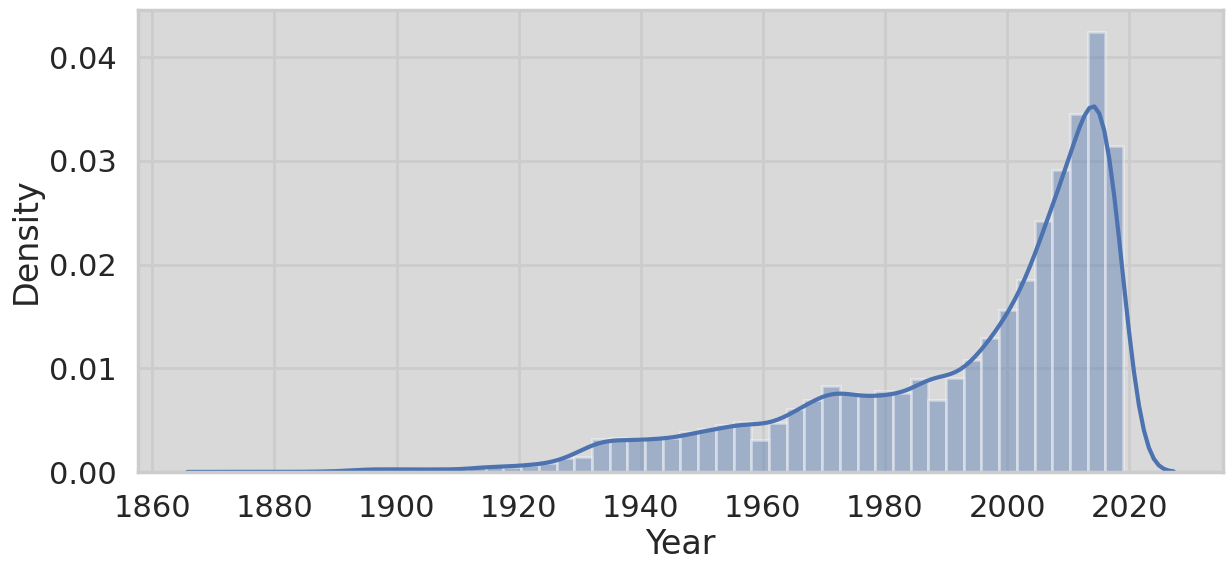

In [29]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.set_context("poster")
sns.set_style("whitegrid", {"axes.facecolor": ".85"})

sns.distplot(df3.Year)

(1970.0, 2020.0)

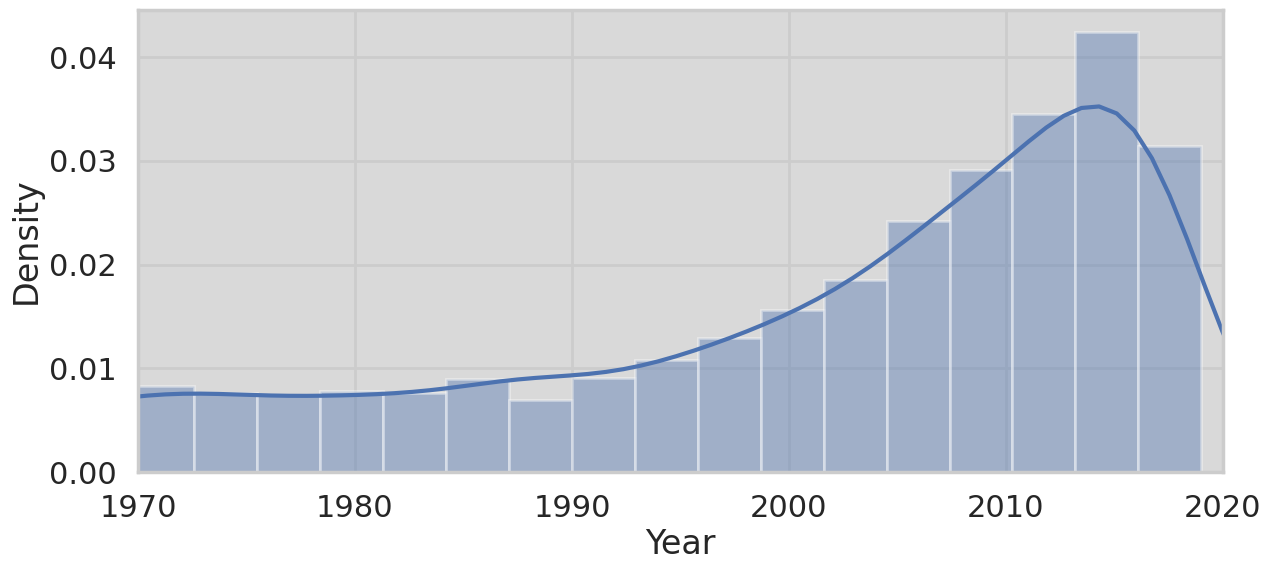

In [30]:
#zooming in:
sns.distplot(df3.Year)
plt.xlim(1970, 2020)

In [31]:
genre = df3.genre1.value_counts()
genre = pd.DataFrame(genre)
genre = genre.reset_index()
genre.rename({'index': 'genre', 'genre1':'Count'}, axis=1, inplace=True)

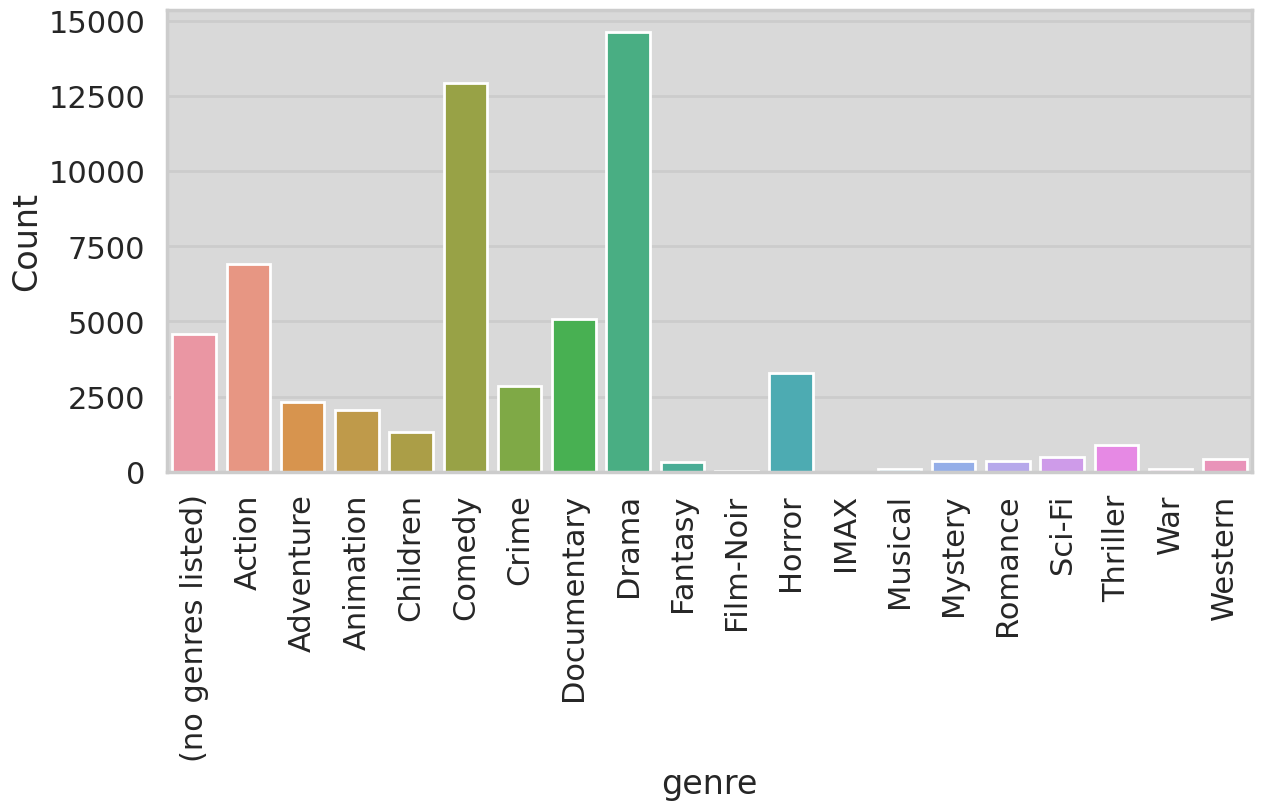

In [32]:
sns.barplot(x = genre.genre, y=genre.Count)
plt.xticks(rotation=90)
plt.show()

In [33]:


genre1 = df3.groupby('genre1')['rating_count'].mean()
genre1 = pd.DataFrame(genre1)
genre1 = genre1.reset_index()
genre1.rename({'rating_count':'avg_count_per_genre'}, axis=1, inplace=True)



Text(0, 0.5, '')

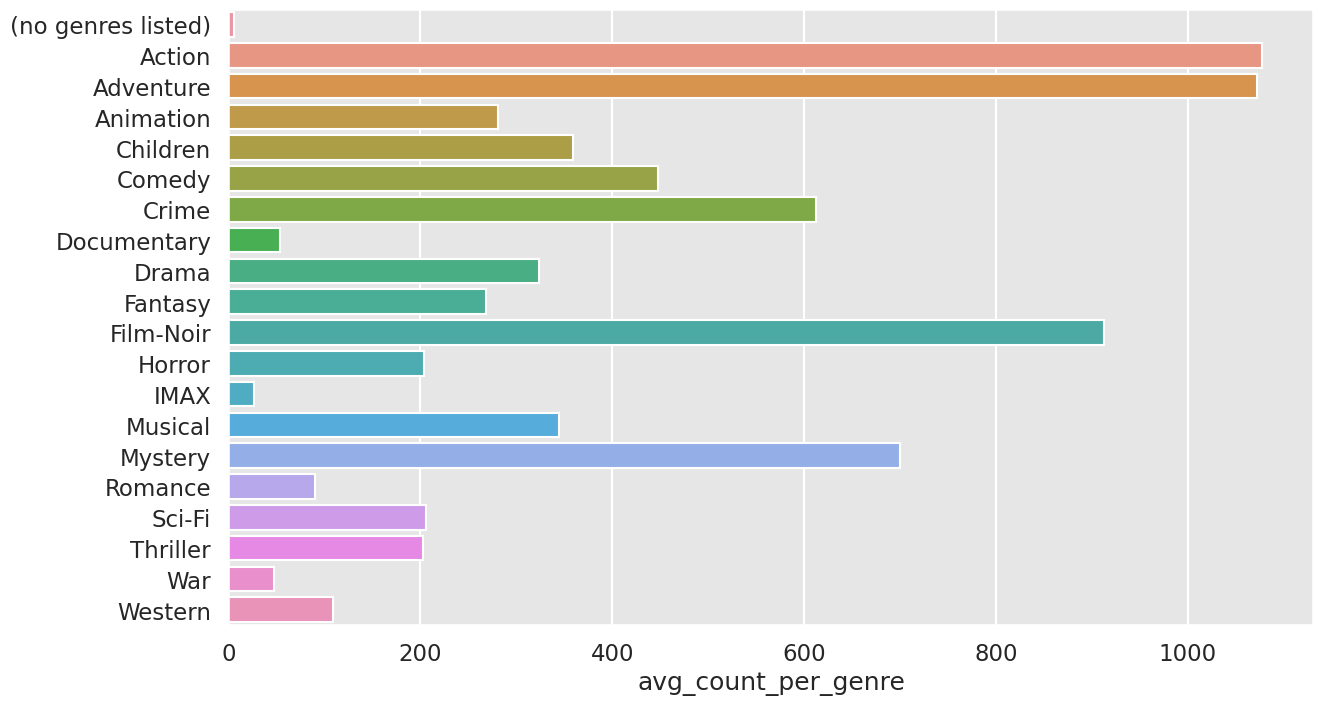

In [36]:
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.barplot(x = genre1.avg_count_per_genre, y=genre1.genre1)
plt.ylabel("")

In [37]:
cols = ['movieId', 'genre1']
b1 = df3[cols]
box_genre = df1.merge(b1, on='movieId', how='inner')

(-2.0, 7.0)

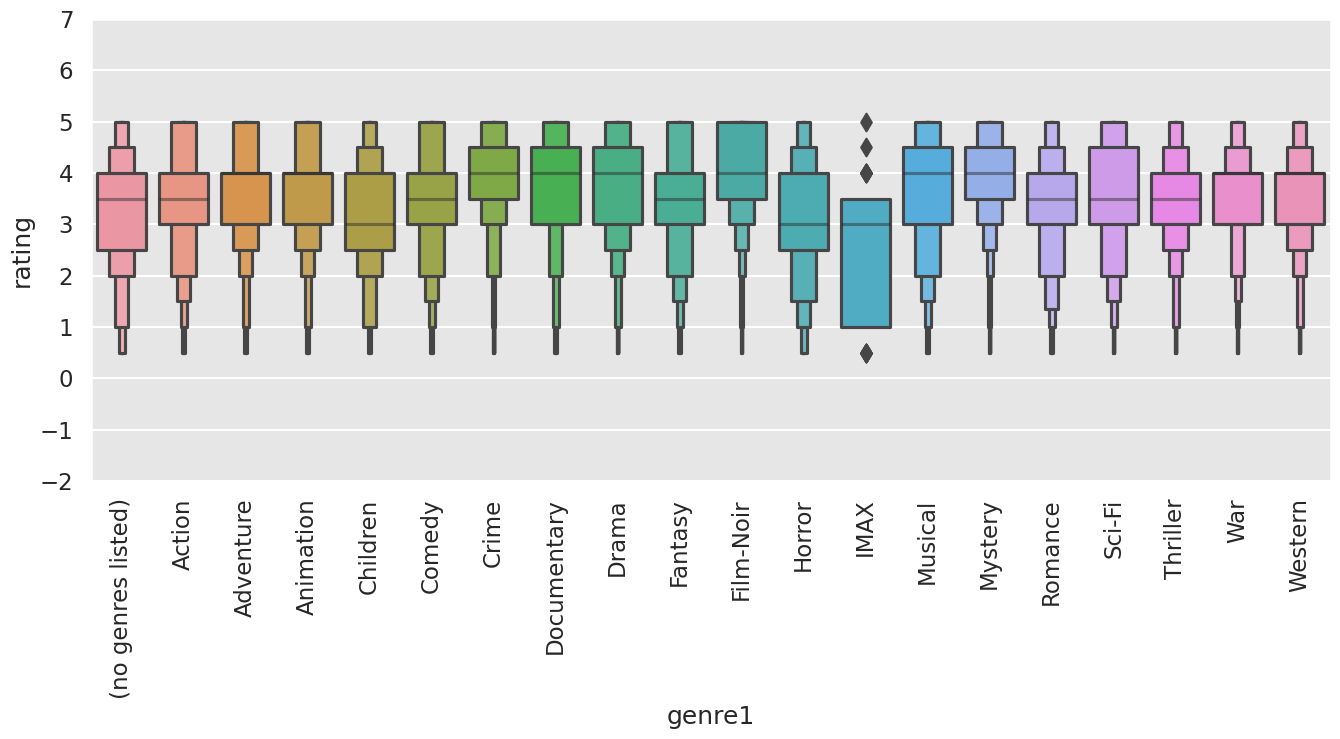

In [38]:
sns.set(rc={'figure.figsize':(16, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre)
plt.xticks(rotation=90)
plt.ylim(-2, 7)

In [39]:
df = df2[df2['genre1']=='Comedy']

In [40]:
from wordcloud import WordCloud

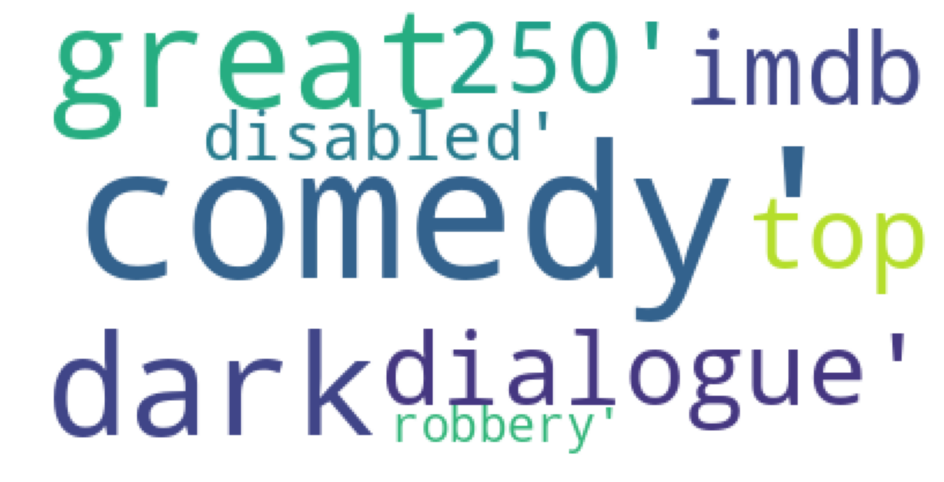

In [44]:
#Drama
text = df['tag'].values

wordcloud = WordCloud(background_color ='white', relative_scaling=0.5).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

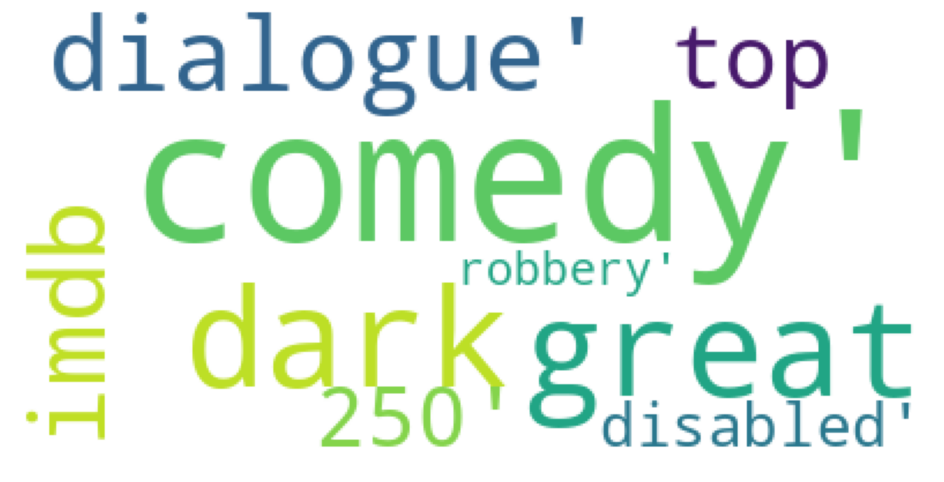

In [45]:
#Action
text = df['tag'].values

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

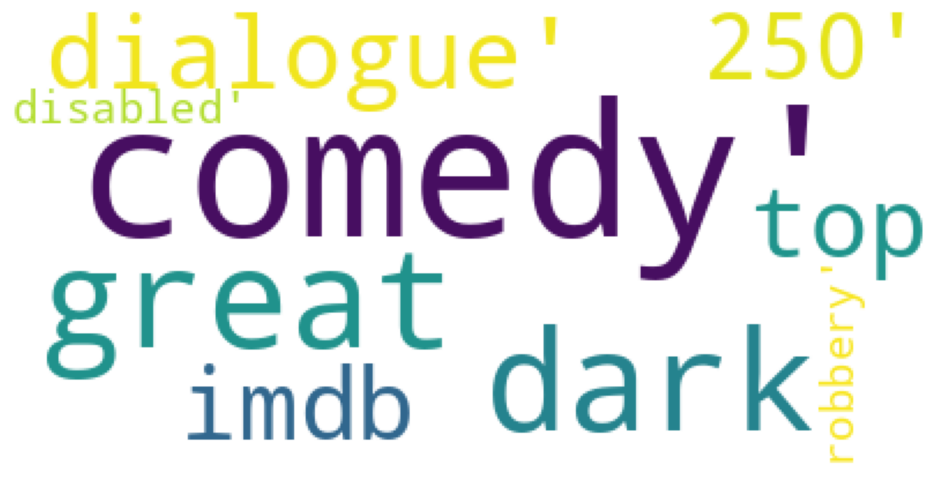

In [47]:
#Comedy
text = df['tag'].values

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [48]:
#movie produced each year for each genre (stacked bar)
genre_by_year = df3.groupby(['Year', 'genre1'])['title'].count().reset_index()
genre_by_year  = pd.DataFrame(genre_by_year)
genre_by_year.tail()


,Year,genre1,title
2695,2019,Romance,7
2696,2019,Sci-Fi,13
2697,2019,Thriller,30
2698,2019,War,1
2699,2019,Western,5


In [50]:
genre_by_year.shape

(2700, 3)

In [52]:
#since we already seen that move of the movies were after 1940s - 1950's, so we filter out every thing before it
genre_by_year1 = genre_by_year[genre_by_year['Year']>='1945']
genre_by_year1.shape

(1500, 3)

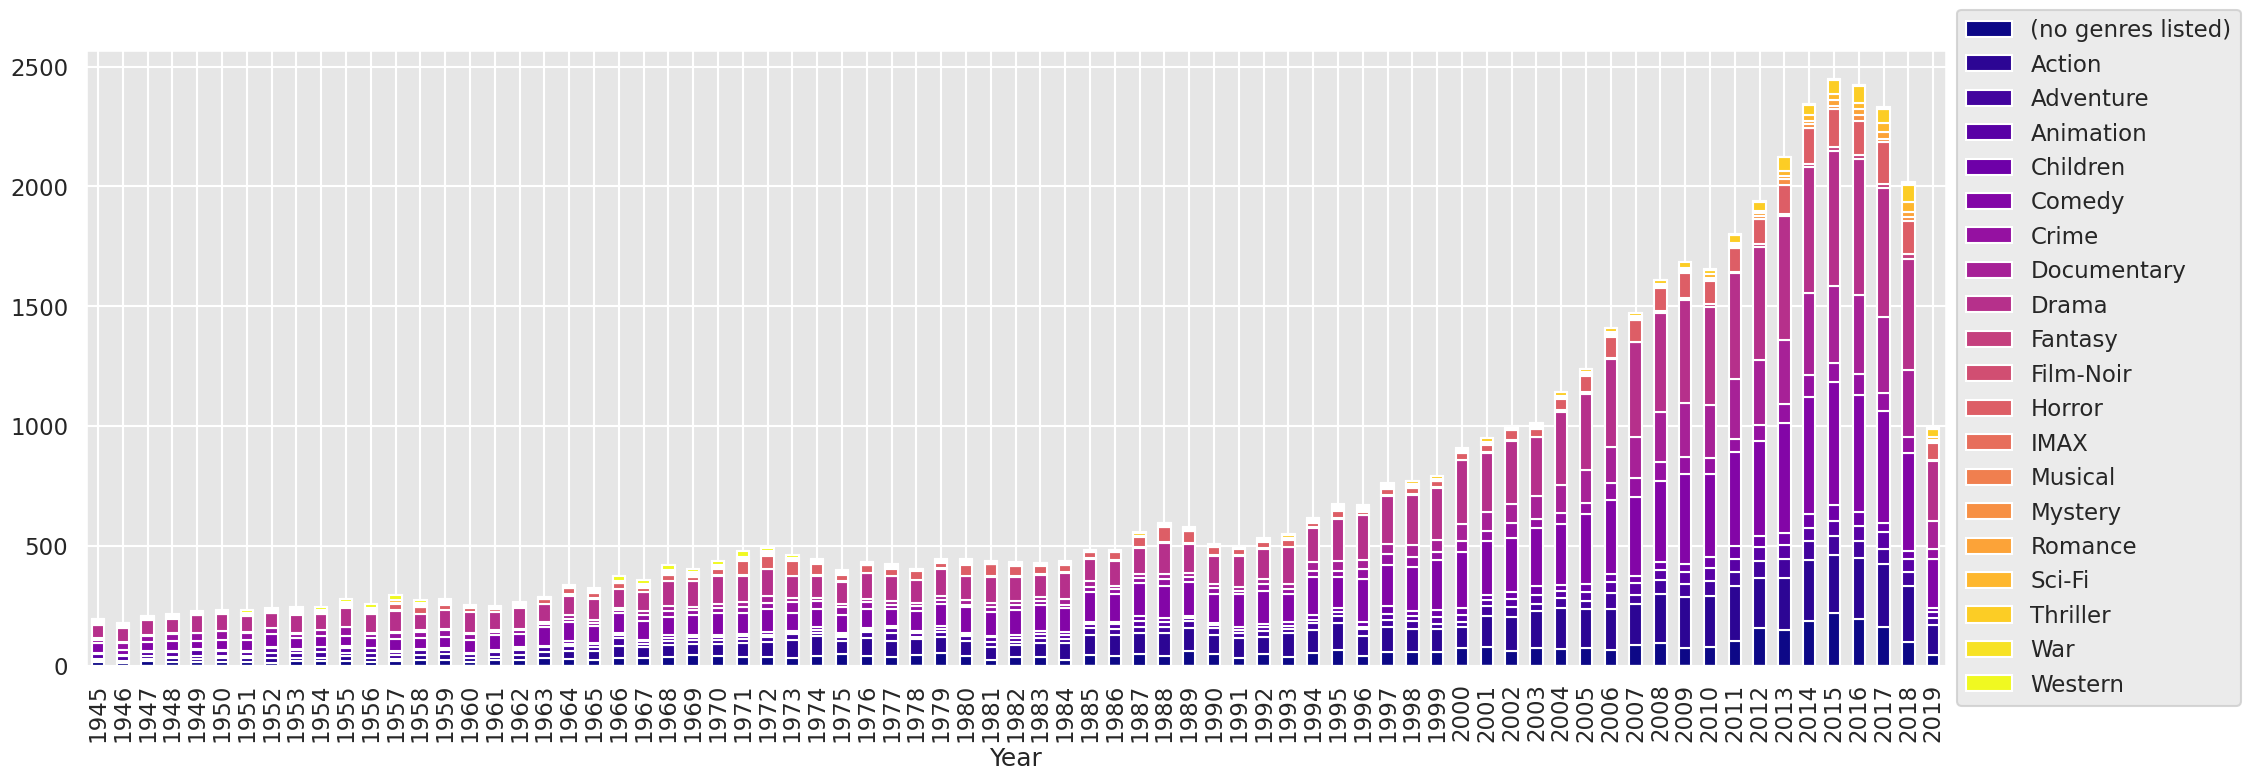

In [53]:
sns.set(rc={'figure.figsize':(24, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_pivot = pd.pivot_table(genre_by_year1, index='Year', columns='genre1', values='title')
df_pivot.plot.bar(stacked=True, colormap='plasma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [54]:


#genre popularity each year
genre_pop = df3.groupby(['genre1', 'Year' ])['avg_rating'].mean().reset_index()
genre_pop  = pd.DataFrame(genre_pop)
genre_pop.tail()



,genre1,Year,avg_rating
2695,Western,2015,3.866135
2696,Western,2016,2.200000
2697,Western,2017,2.806809
2698,Western,2018,3.018092
2699,Western,2019,2.267031


In [55]:
genre_pop1 = genre_pop.copy()



dfgen2 = genre_pop1[genre_pop1['genre1']=='Comedy']
dfgen3 = genre_pop1[genre_pop1['genre1']=='Documentary']
dfgen4 = genre_pop1[genre_pop1['genre1']=='Horror']
dfgen = genre_pop1[genre_pop1['genre1']=='Action']
dfgen1 = genre_pop1[genre_pop1['genre1']=='Drama']



In [56]:


#top 10 movies with rating count via swarmplot
top10_mov = df3.sort_values(by=['rating_count'], ascending=False)
top10_mov = top10_mov.head(10)
cols = ['movieId', 'title']
top10mov = top10_mov[cols]
top10mov.head(10)



,movieId,title
351,356,Forrest Gump (1994)
314,318,"Shawshank Redemption, The (1994)"
292,296,Pulp Fiction (1994)
585,593,"Silence of the Lambs, The (1991)"
2480,2571,"Matrix, The (1999)"
257,260,Star Wars: Episode IV - A New Hope (1977)
475,480,Jurassic Park (1993)
522,527,Schindler's List (1993)
108,110,Braveheart (1995)
2867,2959,Fight Club (1999)


In [57]:


top10mov = top10mov.merge(df1, on = 'movieId', how='inner')
top10mov.shape



(700675, 4)

In [58]:
top10mov.head(10)

,movieId,title,userId,rating
0,356,Forrest Gump (1994),2,4.5
1,356,Forrest Gump (1994),3,4.0
2,356,Forrest Gump (1994),5,4.0
3,356,Forrest Gump (1994),8,5.0
4,356,Forrest Gump (1994),9,5.0
5,356,Forrest Gump (1994),10,4.5
6,356,Forrest Gump (1994),12,4.0
7,356,Forrest Gump (1994),13,5.0
8,356,Forrest Gump (1994),15,5.0
9,356,Forrest Gump (1994),18,3.0


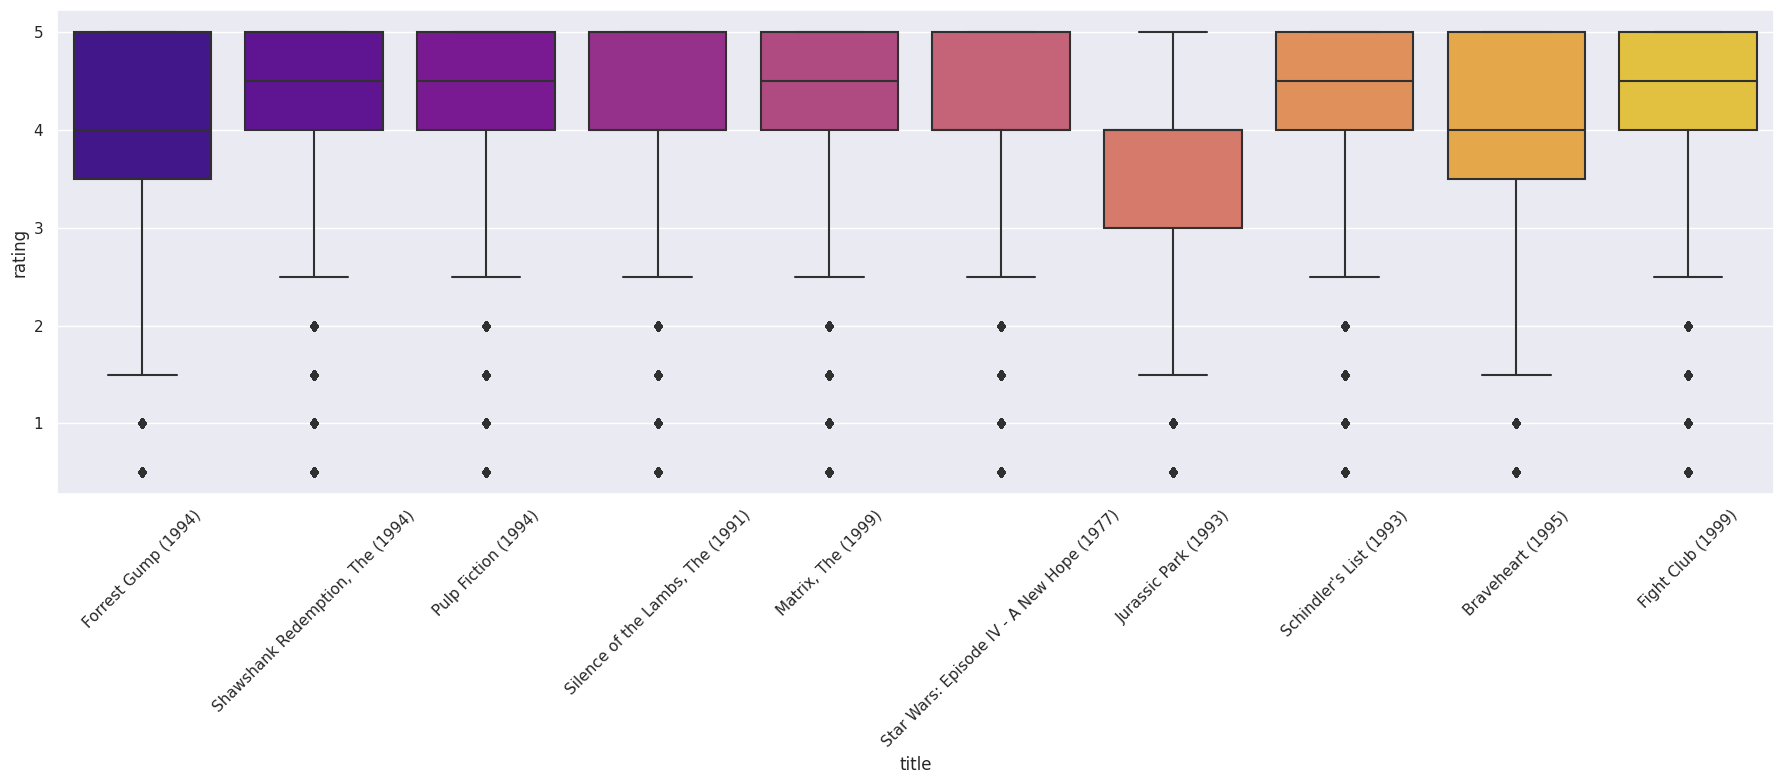

In [59]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.boxplot(x='title', y='rating', data=top10mov, palette ='plasma')
plt.xticks(rotation=45)
plt.tight_layout()

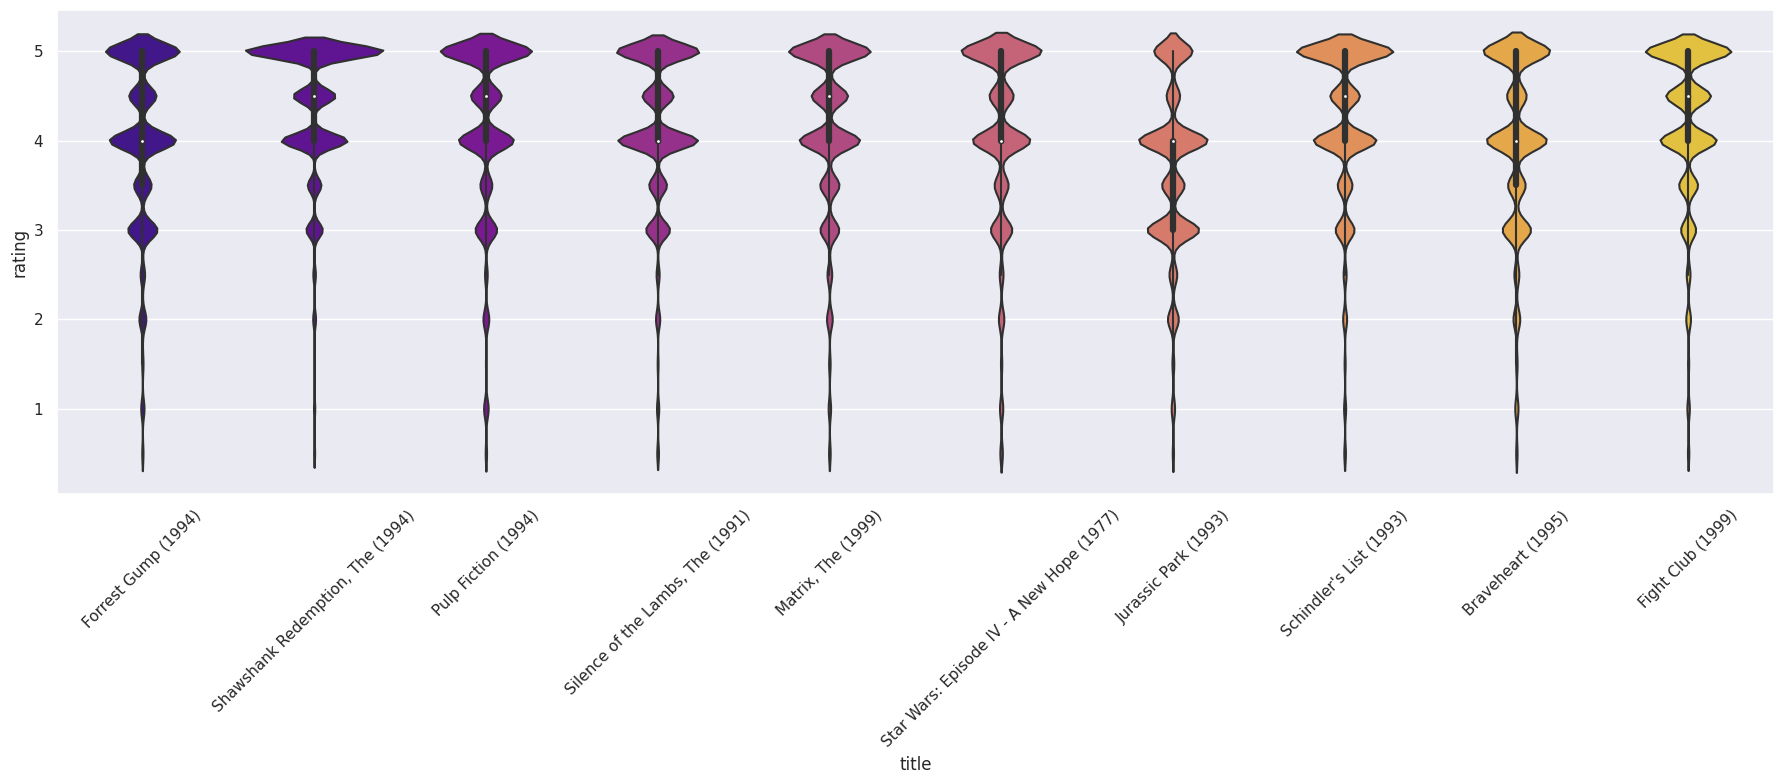

In [60]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.violinplot(x='title', y='rating', data=top10mov, palette ='plasma')
plt.xticks(rotation=45)
plt.tight_layout()


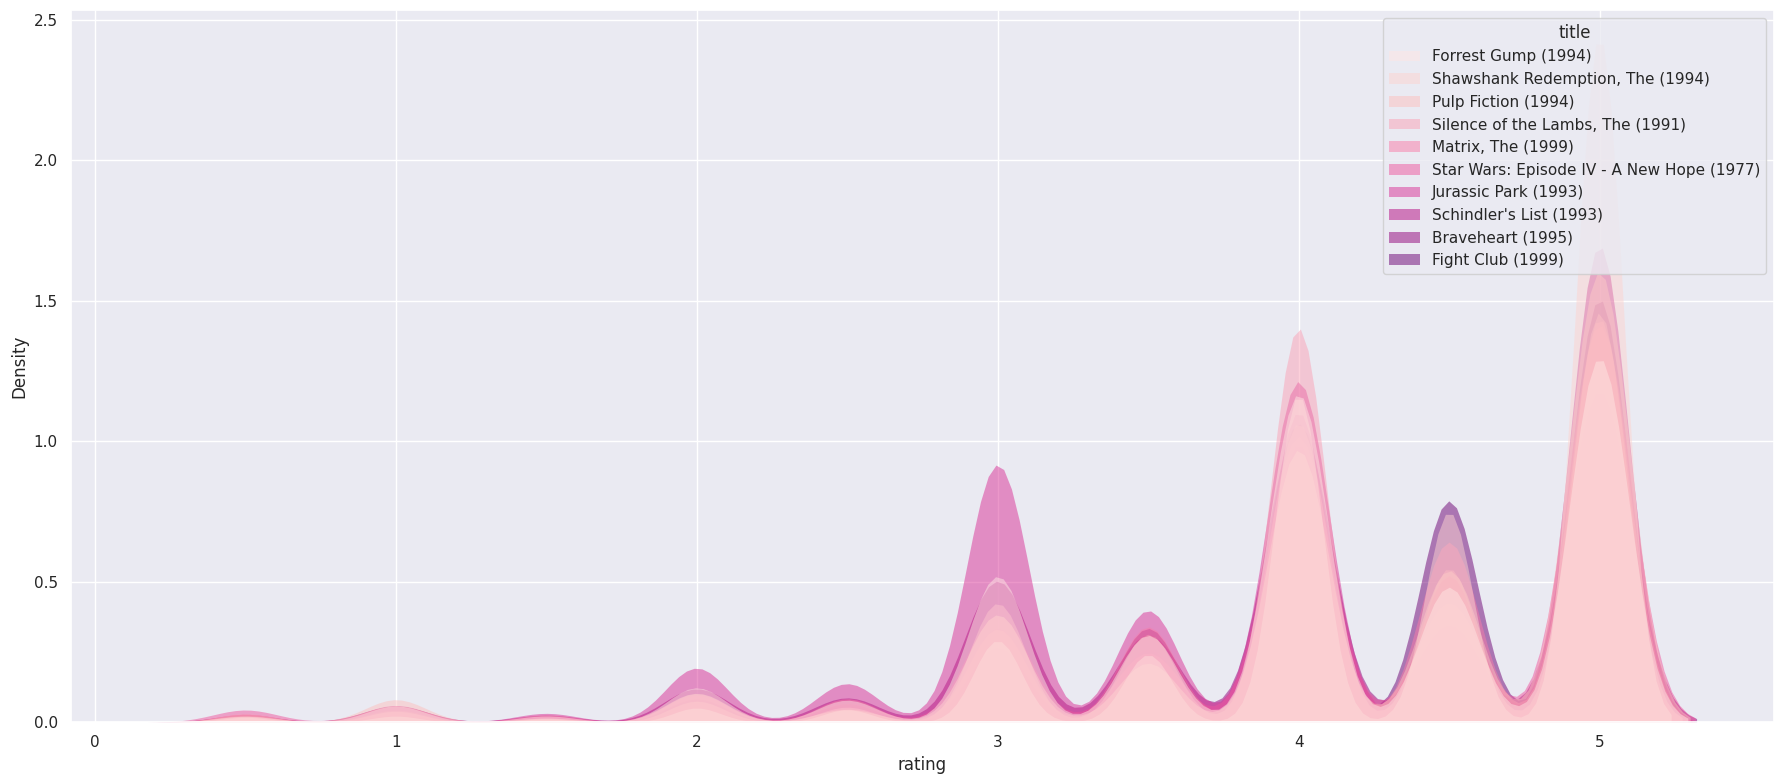

In [61]:
sns.kdeplot(data=top10mov, x='rating', hue='title', fill=True, common_norm=False, palette="RdPu", alpha=.5, linewidth=0,)
plt.tight_layout()

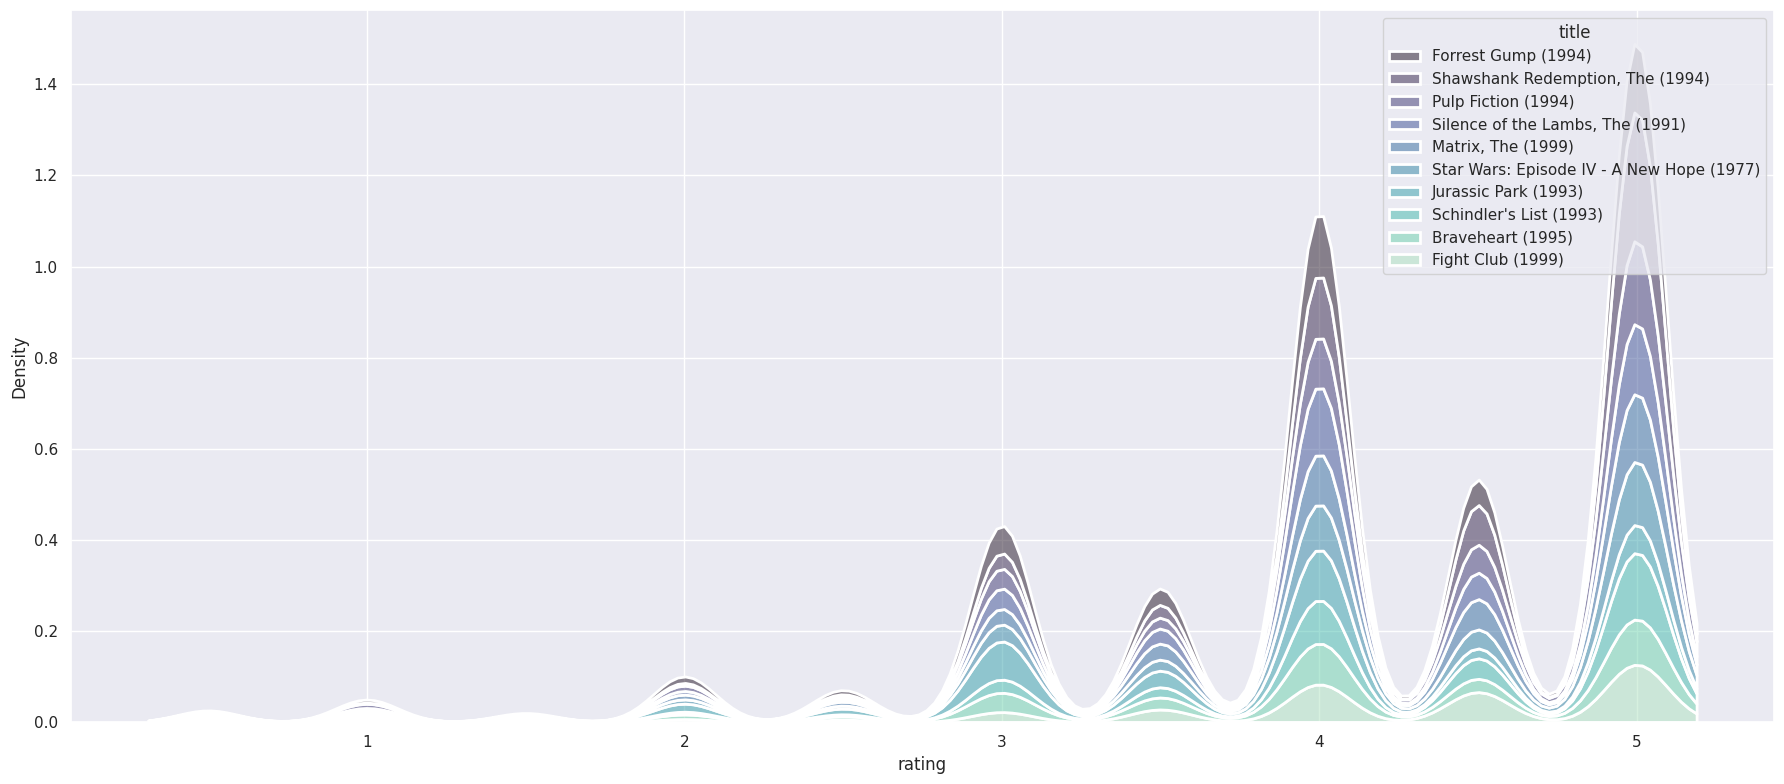

In [62]:
sns.kdeplot(data=top10mov, x='rating', hue='title', alpha=.5, linewidth=2, multiple="stack", palette="mako")
plt.tight_layout()


**Trimmed down to 25k rows for convenience**





In [63]:
#consisit of 25K ratings
ratings = pd.read_csv('/ml-25m/ratings.csv', nrows=25000)

#consist of tags/comments from user
tags = pd.read_csv('/ml-25m/tags.csv', nrows=25000)

#consist of movie titles
movies = pd.read_csv('/ml-25m/movies.csv', nrows=25000)



In [64]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [55]:
# Merge movies and ratings data
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Group by movieId and calculate the mean rating
movie_ratings_mean = movie_ratings.groupby('movieId')['rating'].mean()

# Merge movie_ratings_mean with movies data
movies_with_ratings = pd.merge(movies, movie_ratings_mean, on='movieId')

# Display the first few rows of movies_with_ratings
movies_with_ratings.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.009259
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.108696
2,3,Grumpier Old Men (1995),Comedy|Romance,3.125000
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.000000
4,5,Father of the Bride Part II (1995),Comedy,3.500000


In [65]:
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel  # Import linear_kernel
from sklearn.metrics import jaccard_score
from scipy.stats import pearsonr



def load_data(ratings_file, movies_file, nrows=None):
    # Load and return ratings and movies data
    ratings = pd.read_csv(ratings_file, nrows=nrows)
    movies = pd.read_csv(movies_file, nrows=nrows)
    return ratings, movies

def generate_movie_recommendations(input_movie, ratings, movies):
    # Merge ratings and movies data
    movie_ratings = pd.merge(ratings, movies, on='movieId')

    # Calculate mean ratings and genres for each movie
    movies_with_ratings = movie_ratings.groupby(['movieId', 'title', 'genres'])['rating'].mean().reset_index()

    # Find the movieId of the input movie
    input_movie_id = movies_with_ratings[movies_with_ratings['title'] == input_movie]['movieId'].values[0]

    # Find the genres of the input movie
    input_movie_genres = movies_with_ratings[movies_with_ratings['title'] == input_movie]['genres'].values[0]

    # Filter movies with similar genres
    similar_movies = movies_with_ratings[movies_with_ratings['genres'] == input_movie_genres]

    # Exclude the input movie from recommendations
    similar_movies = similar_movies[similar_movies['movieId'] != input_movie_id]

    # Sort similar_movies by mean rating in descending order
    similar_movies = similar_movies.sort_values(by='rating', ascending=False)

    # Display top 5 recommended movies
    recommended_movies = similar_movies[['title', 'genres', 'rating']].head(5)
    return recommended_movies



def recommend_by_cosine_similarity(input_movie, ratings, movies):
    # Merge ratings and movies data
    movie_ratings = pd.merge(ratings, movies, on='movieId')

    # Create a user-movie rating matrix
    user_movie_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')

    # Fill missing values with 0 (unrated)
    user_movie_ratings = user_movie_ratings.fillna(0)

    # Calculate item similarity using cosine similarity
    item_similarity = cosine_similarity(user_movie_ratings.T)

    # Create a DataFrame from item_similarity
    item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)

    # Find the most similar movies to the input movie
    similar_movies = item_similarity_df[input_movie].sort_values(ascending=False)

    # Display top 5 recommended movies
    recommended_movies = similar_movies.head(5)
    return recommended_movies




def recommend_movies_item_based(input_movie, ratings_file, movies_file, num_recommendations=5):
    # Load the data
    ratings = pd.read_csv(ratings_file, nrows=25000)
    movies = pd.read_csv(movies_file, nrows=25000)

    # Merge ratings and movies data
    movie_ratings = pd.merge(ratings, movies, on='movieId')

    # Create a user-movie rating matrix
    user_movie_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')

    # Fill missing values with 0 (unrated)
    user_movie_ratings = user_movie_ratings.fillna(0)

    # Calculate item similarity using Pearson correlation coefficient
    item_similarity = 1 - pairwise_distances(user_movie_ratings.T, metric='correlation')

    # Create a DataFrame from item_similarity
    item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)

    # Find the most similar movies to the input movie
    similar_movies = item_similarity_df[input_movie].sort_values(ascending=False)

    # Display top recommended movies
    recommended_movies = similar_movies[1:num_recommendations + 1]

    return recommended_movies

import pandas as pd



# Function to generate movie recommendations using Nearest Neighbors
def recommend_movies_knn(input_movie, ratings, movies, num_recommendations=5, k=6):
    # Merge ratings and movies data
    movie_ratings = pd.merge(ratings, movies, on='movieId')

    # Create a user-movie rating matrix
    user_movie_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')

    # Fill missing values with 0 (unrated)
    user_movie_ratings = user_movie_ratings.fillna(0)

    # Initialize and fit NearestNeighbors model
    knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    knn_model.fit(user_movie_ratings.values.T)

    # Find the index of the input movie in the user-movie matrix
    input_movie_index = user_movie_ratings.columns.get_loc(input_movie)

    # Find k most similar movies using KNN
    distances, indices = knn_model.kneighbors([user_movie_ratings.values.T[input_movie_index]], n_neighbors=k)

    # Display recommended movies
    recommended_movies = user_movie_ratings.columns[indices.flatten()[1:]]
    return recommended_movies[:num_recommendations]
















In [67]:
# Get input movie title from the user
input_movie = input("Enter a movie title: ")

# Load data
ratings, movies = load_data('/ml-25m/ratings.csv', '/ml-25m/movies.csv', nrows=25000)



# Generate and display recommendations
# recommendations = generate_movie_recommendations(input_movie, ratings, movies)
# recommendations = recommend_by_cosine_similarity(input_movie, ratings, movies)
recommendations = recommend_movies_knn(input_movie, ratings, movies, num_recommendations=5, k=6)

print("\nRecommended Movies:")
print(recommendations)

Enter a movie title: Toy Story (1995)

Recommended Movies:
Index(['Star Wars: Episode IV - A New Hope (1977)',
       'Independence Day (a.k.a. ID4) (1996)', 'Toy Story 2 (1999)',
       'Lion King, The (1994)', 'Forrest Gump (1994)'],
      dtype='object', name='title')


**User based recommendation ...**

Find interesting movies on user preferences

In [68]:

def recommend_by_user(input_user_id, ratings, movies):
    # Merge ratings and movies data
    movie_ratings = pd.merge(ratings, movies, on='movieId')

    # Filter ratings for the input user
    user_ratings = movie_ratings[movie_ratings['userId'] == input_user_id]

    # Get movies rated highly by the user
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4.0]

    # Get movie genres from highly rated movies
    user_genres = high_rated_movies['genres'].str.split('|').explode().unique()

    # Filter movies with user-preferred genres
    recommended_movies = movies[movies['genres'].str.contains('|'.join(user_genres))]

    # Exclude movies already rated by the user
    recommended_movies = recommended_movies[~recommended_movies['movieId'].isin(high_rated_movies['movieId'])]

    # Display top 5 recommended movies
    return recommended_movies.head(5)




In [70]:
# Get input user ID from the user
input_user_id = int(input("Enter your user ID: "))

# Load data
ratings, movies = load_data('/ml-25m/ratings.csv', '/ml-25m/movies.csv', nrows=25000)

# Generate and display user-based recommendations
user_recommendations = recommend_by_user(input_user_id, ratings, movies)
print("\nUser-Based Recommendations:")
print(user_recommendations[['title', 'genres']])

Enter your user ID: 2

User-Based Recommendations:
                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


**Genre based Recommendation ...**


In [71]:

def recommend_by_genre(input_genre, movies):
    # Filter movies with the input genre
    recommended_movies = movies[movies['genres'].str.contains(input_genre, case=False)]

    # Display top 5 recommended movies
    return recommended_movies.head(5)

# Get input genre from the user
input_genre = input("Enter a genre: ")

# Load data
_, movies = load_data('/ml-25m/ratings.csv', '/ml-25m/movies.csv', nrows=25000)

# Generate and display genre-based recommendations
genre_recommendations = recommend_by_genre(input_genre, movies)
print("\nGenre-Based Recommendations:")
print(genre_recommendations[['title', 'genres']])


Enter a genre: comedy

Genre-Based Recommendations:
                                title  \
0                    Toy Story (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   
6                      Sabrina (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
6                               Comedy|Romance  


In [72]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Sentiment based + User rating based scoring

In [73]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

# Load the data
ratings = pd.read_csv('/ml-25m/ratings.csv', nrows=25000)
tags = pd.read_csv('/ml-25m/tags.csv', nrows=25000)
movies = pd.read_csv('/ml-25m/movies.csv', nrows=25000)

# Merge ratings and movies data
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Create a user-movie rating matrix
user_movie_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')

# Fill missing values with 0 (unrated)
user_movie_ratings = user_movie_ratings.fillna(0)

# Load comments/tags data
movie_tags = tags.groupby('movieId')['tag'].apply(' '.join).reset_index()
movie_tags = pd.merge(movie_tags, movies[['movieId', 'title']], on='movieId')

# Initialize sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Tokenize and analyze comments to get sentiment scores
tokenizer = RegexpTokenizer(r'\w+')

def get_sentiment_score(comment):
    tokens = tokenizer.tokenize(comment)
    sentiment_scores = sentiment_analyzer.polarity_scores(' '.join(tokens))
    return sentiment_scores['compound']

movie_tags['sentiment_score'] = movie_tags['tag'].apply(get_sentiment_score)

# Calculate item similarity using cosine similarity
item_similarity = cosine_similarity(user_movie_ratings.T)

# Create a DataFrame from item_similarity
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_ratings.columns, columns=user_movie_ratings.columns)

# Initialize the TF-IDF vectorizer for sentiments
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sentiment scores using TF-IDF
sentiment_tfidf = tfidf_vectorizer.fit_transform(movie_tags['sentiment_score'].apply(str))

# Calculate the cosine similarity between sentiment scores using TF-IDF vectors
sentiment_similarity = cosine_similarity(sentiment_tfidf, sentiment_tfidf)

# Create a DataFrame from sentiment_similarity
sentiment_similarity_df = pd.DataFrame(sentiment_similarity, index=movie_tags['title'], columns=movie_tags['title'])

# Get input movie title from the user
input_movie = input("Enter a movie title: ")

# Find the most similar movies based on both user ratings and sentiment scores
similar_movies = 0.9 * item_similarity_df[input_movie] + 0.1 * sentiment_similarity_df[input_movie]
similar_movies = similar_movies.sort_values(ascending=False)

# Display top 3 recommended movies
recommended_movies = similar_movies[1:4]
print("\nRecommended Movies:")
print(recommended_movies)


Enter a movie title: Toy Story (1995)

Recommended Movies:
title
Star Wars: Episode IV - A New Hope (1977)    0.520625
Independence Day (a.k.a. ID4) (1996)         0.510233
Toy Story 2 (1999)                           0.502216
Name: Toy Story (1995), dtype: float64
